In [13]:
import numpy as np
import matplotlib.pyplot as plt
from jinja2.optimizer import optimize
from scipy.stats import norm, uniform
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from bayes_opt import BayesianOptimization

# Simple Example of GP Based Distribution Modelling

## `STEP 1`: Define $p(s_t) = \mathcal{N} \approx (\mu_{st} , \sigma_{st})$ 
## and $f(p(s_t)) = c.d.f (\mathcal{GP})$

In [14]:
def f_gp(mu_st, sigma_st):
    s_t = np.random.normal(mu_st, sigma_st)
    # transform s_t to a_t using the cdf of Gaussian Process
    a_t = norm.cdf(s_t, loc=mu_st, scale=sigma_st)
    return a_t

## `STEP 2`: Define the Objective Function
## $minimize \| p(A_t) - Uniform \| \approx D_{KL} (p(A_t)) \| Uniform$
## OR
## $minimize \| p(A_t) - Uniform \| \approx D_{TL} (p(A_t)) \| Uniform$

In [15]:
def l2NormObjective(mu_st, sigma_st):
    a_t = f_gp(mu_st, sigma_st)
    # discretize a_t using histograms
    hist_a_t, bin_edges = np.histogram(a_t, bins=32, density=True)
    # the Uniform is spread of the entirety of p_a_t
    uniform_hist = np.ones_like(hist_a_t) / len(hist_a_t)
    distance = np.linalg.norm(hist_a_t - uniform_hist)
    # minimizing distance is the same as maximizing the negative of distance
    return -distance

## `STEP 3`: Setup the Gaussian Process
## Compute $\mathcal{GP} = \mu , K(X, \hat{X})$


In [16]:
kernel = C(constant_value=1.0, constant_value_bounds=(1e-4, 1e1)) * RBF(length_scale=1.0,
                                                                        length_scale_bounds=(1e-4, 1e1))
GP = GaussianProcessRegressor(kernel=kernel, random_state=0, n_restarts_optimizer=10)

## `STEP 4`: Bayesian Optimisation - Setup the optimiser

In [17]:
# first you need to define the bounds for which the mu_st and sigma_st can take
bounds = {'mu_st': (-5.0, 5.0), 'sigma_st': (0.1, 3.0)}
# set up the optimiser
optimiser = BayesianOptimization(
    f=l2NormObjective,
    pbounds=bounds,
    random_state=64
)

## `STEP 5`: Run the Optimisation problem

In [18]:
optimiser.maximize(init_points=5, n_iter=20)

|   iter    |  target   |   mu_st   | sigma_st  |
-------------------------------------------------
| 1         | -31.97    | -1.209    | 1.745     |
| 2         | -31.97    | 0.9559    | 1.405     |
| 3         | -31.97    | -0.4298   | 1.004     |
| 4         | -31.97    | -1.867    | 0.9551    |
| 5         | -31.97    | 0.3077    | 1.249     |
| 6         | -31.97    | 4.959     | 2.954     |
| 7         | -31.97    | -0.6412   | 1.34      |
| 8         | -31.97    | -0.7106   | 2.321     |
| 9         | -31.97    | -4.988    | 0.1469    |
| 10        | -31.97    | 4.417     | 0.2951    |
| 11        | -31.97    | 2.879     | 2.811     |
| 12        | -31.97    | 1.733     | 0.1103    |
| 13        | -31.97    | -2.298    | 2.991     |
| 14        | -31.97    | 4.245     | 1.827     |
| 15        | -31.97    | 0.3826    | 2.948     |
| 16        | -31.97    | 2.301     | 2.033     |
| 17        | -31.97    | 3.425     | 0.9568    |
| 18        | -31.97    | -0.8956   | 0.1387    |


In [21]:
# Display the best parameters found
print("Best configuration found:")
best_params = optimiser.max['params']
print(best_params)

Best configuration found:
{'mu_st': -1.2090147456622988, 'sigma_st': 1.7445846848208808}


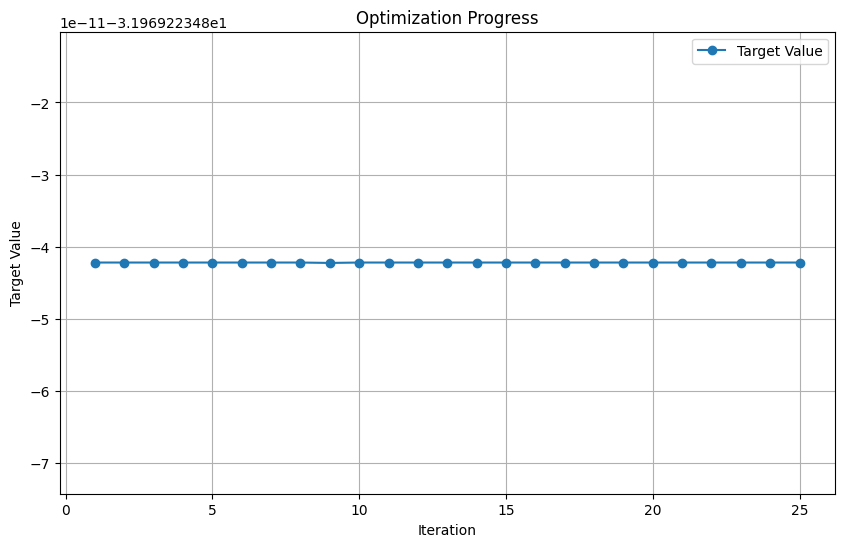

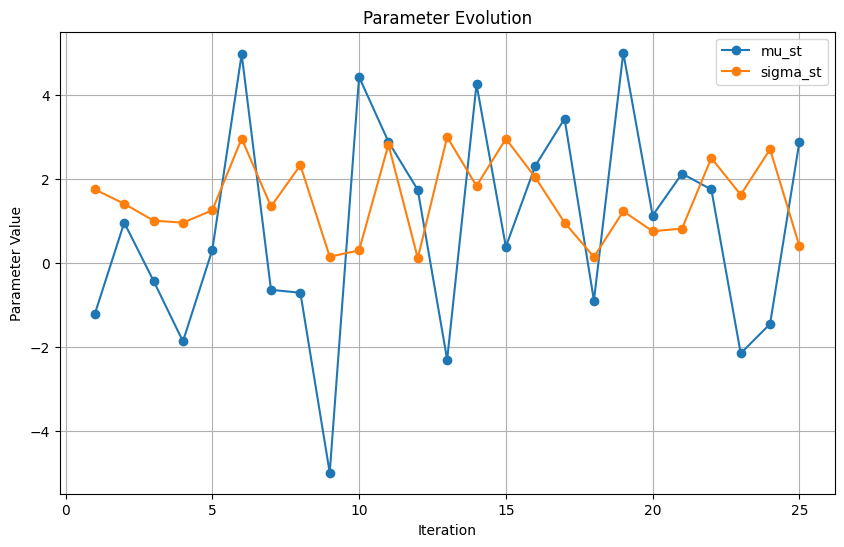

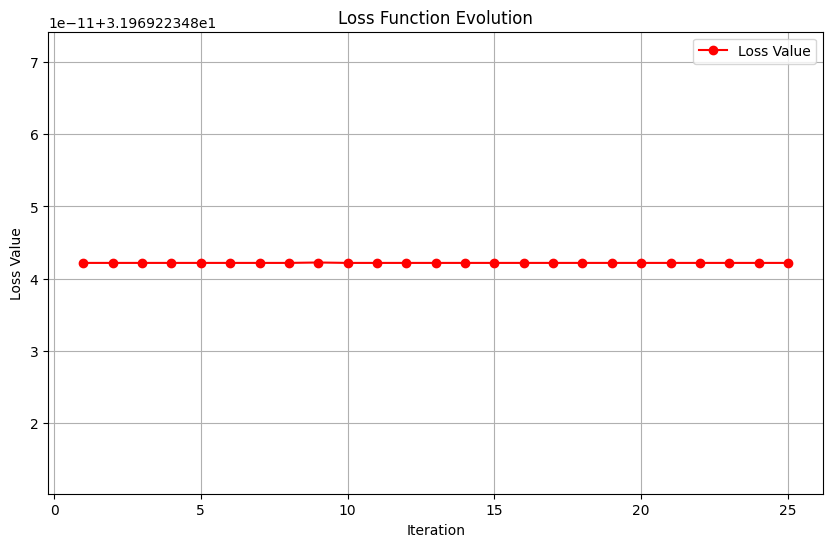

In [24]:
iterations = list(range(1, len(optimiser.res) + 1))
target_values = [res['target'] for res in optimiser.res]
mu_st_values = [res['params']['mu_st'] for res in optimiser.res]
sigma_st_values = [res['params']['sigma_st'] for res in optimiser.res]
loss_values = [-val for val in target_values] 

# Plot target value progression
plt.figure(figsize=(10, 6))
plt.plot(iterations, target_values, marker='o', label='Target Value')
plt.xlabel('Iteration')
plt.ylabel('Target Value')
plt.title('Optimization Progress')
plt.grid()
plt.legend()
plt.show()

# Optional: Plot parameters vs iterations
plt.figure(figsize=(10, 6))
plt.plot(iterations, mu_st_values, marker='o', label='mu_st')
plt.plot(iterations, sigma_st_values, marker='o', label='sigma_st')
plt.xlabel('Iteration')
plt.ylabel('Parameter Value')
plt.title('Parameter Evolution')
plt.grid()
plt.legend()
plt.show()

# Plot loss function evolution
plt.figure(figsize=(10, 6))
plt.plot(iterations, loss_values, marker='o', label='Loss Value', color='red')
plt.xlabel('Iteration')
plt.ylabel('Loss Value')
plt.title('Loss Function Evolution')
plt.grid()
plt.legend()
plt.show()